In [1]:
import sys 
sys.path.append('..')

from models import DIFSampler,SoftmaxWeight,LocationScaleFlow
from targets import Target
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt

In [2]:
from matplotlib.colors import ListedColormap
import numpy as np
N = 256
orange = np.ones((N, 4))
orange[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
orange[:, 1] = np.geomspace(165 / 256, 1, N)  # G = 165
orange[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
orange_cmap = ListedColormap(orange[::-1])

orange_color = "#FFA500"

red = np.ones((N, 4))
red[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
red[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
red[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
red_cmap = ListedColormap(red[::-1])

red_color = "#FF0000"

blue = np.ones((N, 4))
blue[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
blue[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
blue[:, 2] = np.geomspace(255 / 256, 1, N)  # B = 255
blue_cmap = ListedColormap(blue[::-1])

blue_color = "#0000FF"

green = np.ones((N, 4))
green[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
green[:, 1] = np.geomspace(128 / 256, 1, N)  # G = 128
green[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 128
green_cmap = ListedColormap(green[::-1])

green_color = "#008000"

pink = np.ones((N, 4))
pink[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
pink[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
pink[:, 2] = np.geomspace(211 / 256, 1, N)  # B = 211
pink_cmap = ListedColormap(pink[::-1])

pink_color = "#FF00D3"

purple = np.ones((N, 4))
purple[:, 0] = np.geomspace(51 / 256, 1, N)  # R = 102
purple[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
purple[:, 2] = np.geomspace(51 / 256, 1, N)  # B = 102
purple_cmap = ListedColormap(purple[::-1])

purple_color = "#660066"

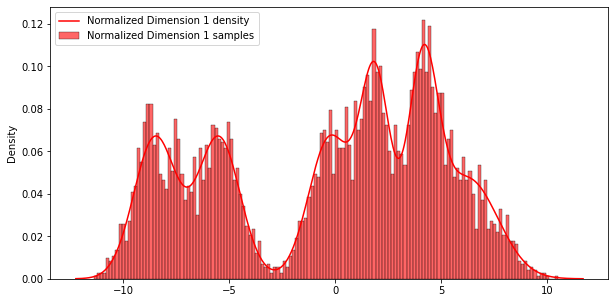

In [3]:
example = "Normalized Dimension 1"
num_samples = 50000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [4]:
epochs = 100
K = 20
num_samples= 50000
batch_size = 5000
dif = DIFSampler(target_log_density,p,K)
dif.w = SoftmaxWeight(K,p, [])
dif.train(epochs,num_samples, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it, loss = 0.028929]


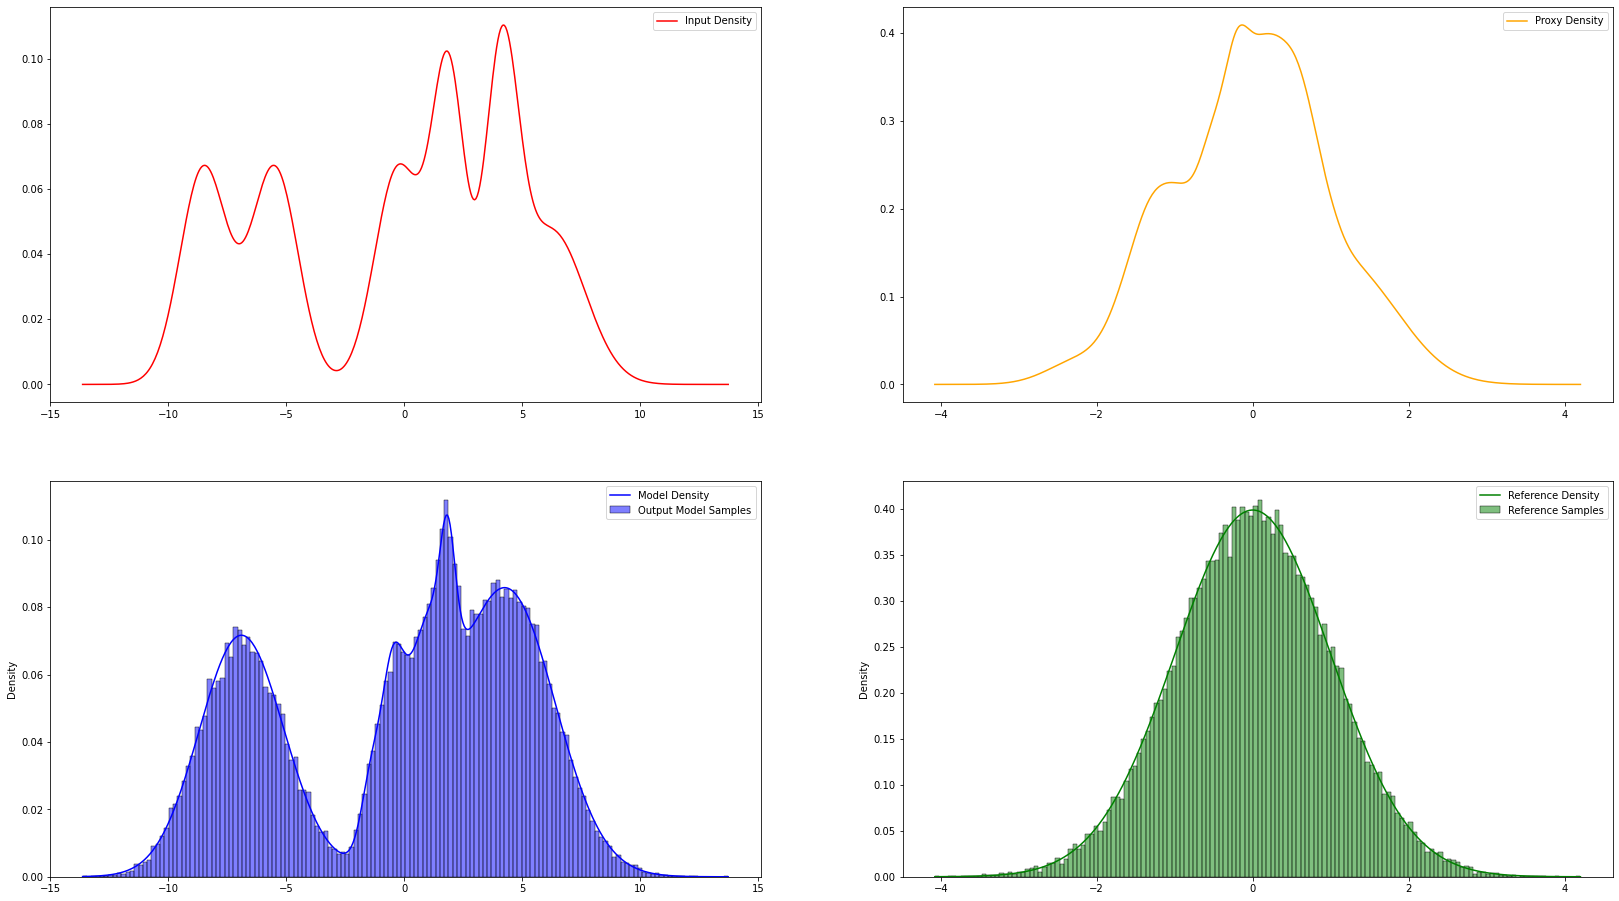

In [5]:
### Visualize DIF density estimation dimension 1 ###

model_to_visualize = dif
import seaborn as sns
linspace = 500
with torch.no_grad():
    reference_samples = model_to_visualize.reference.sample(num_samples).cpu()
    tt_r = torch.linspace(torch.min(reference_samples), torch.max(reference_samples), linspace).unsqueeze(
        1)
    proxy_density = torch.exp(model_to_visualize.proxy_log_density(tt_r)).cpu()
    reference_density = torch.exp(model_to_visualize.reference.log_density(tt_r)).cpu()

    model_samples = model_to_visualize.sample_model(num_samples)
    tt = torch.linspace(torch.min(model_samples), torch.max(model_samples), linspace).unsqueeze(1)
    model_density = torch.exp(model_to_visualize.model_log_density(tt))
    target_density = torch.exp(model_to_visualize.target_log_density(tt))

fig = plt.figure(figsize=(28, 16))
ax1 = fig.add_subplot(221)
ax1.plot(tt.cpu(), target_density.cpu(), color=red_color, label="Input Density")
ax1.legend()

ax4 = fig.add_subplot(224)
ax4.plot(tt_r.cpu(), reference_density.cpu(), color=green_color, label='Reference Density')
sns.histplot(reference_samples[:, 0].cpu(), stat="density", alpha=0.5, bins=150, color=green_color,
             label="Reference Samples")
ax4.legend()

ax2 = fig.add_subplot(222, sharex=ax4)
ax2.plot(tt_r.cpu(), proxy_density.cpu(), color=orange_color, label='Proxy Density')
ax2.legend()

ax3 = fig.add_subplot(223, sharex=ax1)
sns.histplot(model_samples[:, 0].cpu(), stat="density", alpha=0.5, bins=150, color=blue_color,
             label="Output Model Samples")
ax3.plot(tt.cpu(), model_density.cpu(), color=blue_color, label="Model Density")
ax3.legend()

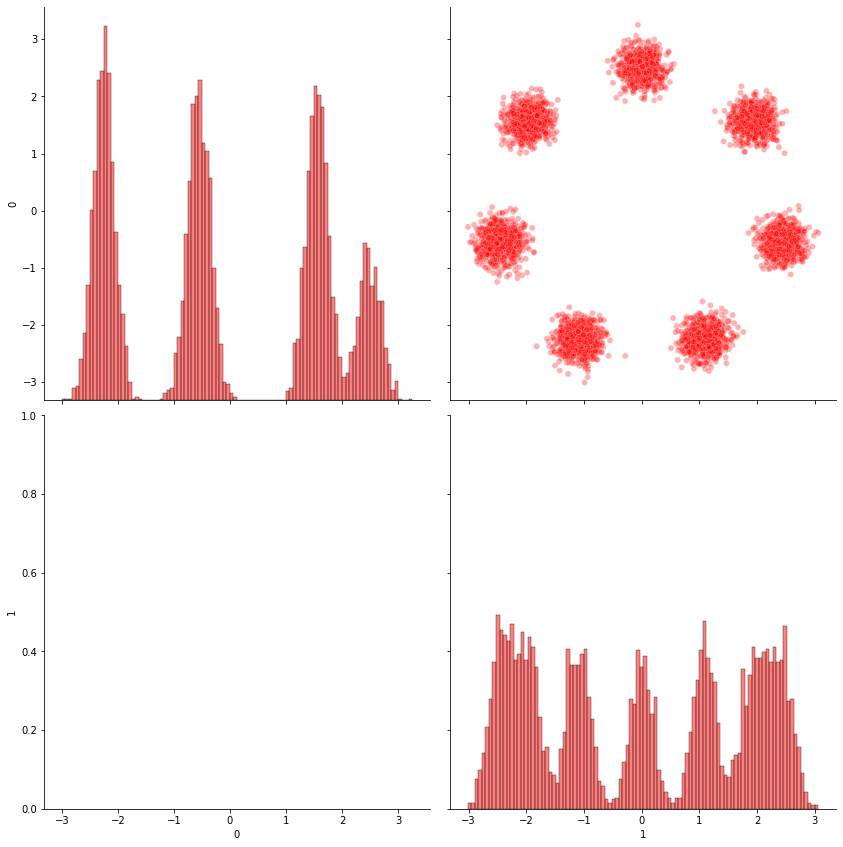

In [6]:
example = "Orbits"
num_samples = 50000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [7]:
epochs = 200
K = 10
dif = DIFSampler(target_log_density,p, K)
dif.w = SoftmaxWeight(K,p, [64,64,64])
dif.train(epochs,num_samples,5000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:50<00:00,  1.75s/it, loss = 0.110339]


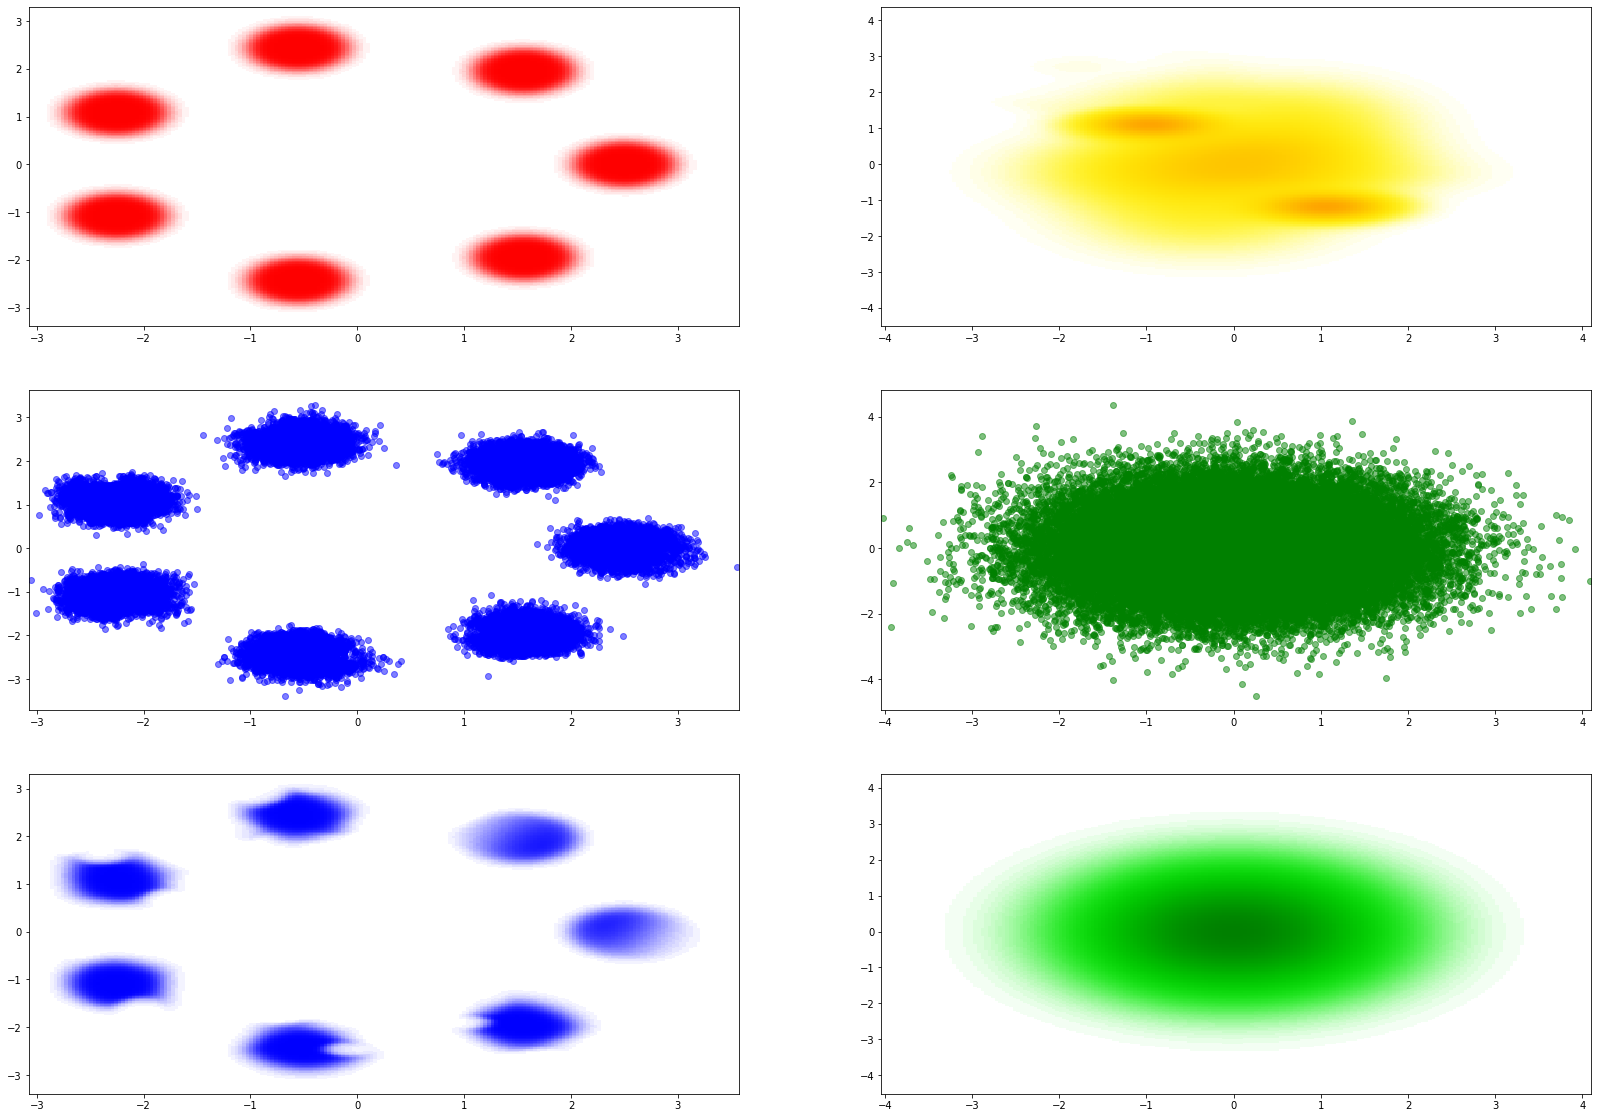

In [10]:
###Visualize DIF sampler dimension 2 ###

model_to_visualize = dif

linspace = 200
with torch.no_grad():
    model_samples = model_to_visualize.sample_model(num_samples)
    reference_samples = model_to_visualize.reference.sample(num_samples)
    x0_min = min(model_samples[:,0])
    x0_max = max(model_samples[:,0])
    x1_min = min(model_samples[:,1])
    x1_max = max(model_samples[:,1])
    x_grid = torch.cartesian_prod(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace))
    density_model = torch.exp(model_to_visualize.model_log_density(x_grid).reshape(linspace,linspace))
    density_target = torch.exp(model_to_visualize.target_log_density(x_grid).reshape(linspace,linspace))
    z0_min = min(reference_samples[:,0])
    z0_max = max(reference_samples[:,0])
    z1_min = min(reference_samples[:,1])
    z1_max = max(reference_samples[:,1])
    z_grid = torch.cartesian_prod(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace))
    density_proxy = torch.exp(model_to_visualize.proxy_log_density(z_grid).reshape(linspace,linspace))
    density_reference = torch.exp(model_to_visualize.reference.log_density(z_grid).reshape(linspace,linspace))
fig = plt.figure(figsize=(28, 20))

ax1 = fig.add_subplot(321)
ax1.pcolormesh(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace), density_target.T, cmap = red_cmap)

ax2 = fig.add_subplot(322)
ax2.pcolormesh(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace), density_proxy.T, cmap = orange_cmap)

ax3 = fig.add_subplot(323, sharex=ax1)
ax3.scatter(model_samples[:,0], model_samples[:,1], alpha = 0.5,color=blue_color, label="Output model density")

ax4 = fig.add_subplot(324, sharex=ax2)
ax4.scatter(reference_samples[:, 0],reference_samples[:, 1], alpha=0.5, color=green_color,label='Reference samples')

ax5 = fig.add_subplot(325, sharex=ax1)
ax5.pcolormesh(torch.linspace(x0_min, x0_max,linspace),torch.linspace(x1_min, x1_max,linspace), density_model.T, cmap = blue_cmap)

ax6 = fig.add_subplot(326, sharex=ax2)
ax6.pcolormesh(torch.linspace(z0_min, z0_max,linspace),torch.linspace(z1_min, z1_max,linspace), density_reference.T, cmap = green_cmap)